<a href="https://colab.research.google.com/github/federicodecillia/prophet_pack/blob/main/Prophet_Pack_Example_Usages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Import packages and define class & functions
Tip: In order to hide the content of all the functions it's possible to fold each function by enabling Code Folding in "Tools - Settings - Editor - Enable code folding in the editor"

In [ ]:
############--- Install & import python packages ---############
import numpy as np
import pandas as pd
from pathlib import Path
import os
from datetime import datetime, date
import time
import traceback
import warnings
from itertools import product
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

############--- fbprophet packages ---############
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot
import altair as alt
from fbprophet.plot import plot_plotly
import plotly.offline as py

############--- Google Colab & Google Sheet packages ---############
!pip install --upgrade gspread
import io
import google.colab 
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

############--- DEFINE CLASS & FUNCTIONS USED LATER IN THE SCRIPT ---############
def create_grid(param_grid: dict) -> object:
    '''generate a grid, containing all the combination of parameters.

    Args:
        param_grid: dictionary containing the possible parameters of each model desired to be run. In the format:
            {'model' : [m], 'initial' : ['730 days','400 days'], 'period'  : ['180 days'], 'horizon' : ['365 days']}
    Returns:
        list: grid of parameters
    '''
    param_grid_list = [param_grid].copy()
    for p in param_grid_list:
        items = sorted(p.items())
        if not items:
            yield {}
        else:
            keys, values = zip(*items)
            for v in product(*values):
                params = dict(zip(keys, v))
                yield params

def create_ts(df: pd.DataFrame, date_var: str, y_var: str, x_vars: list = False, sort_ts: bool = False):
    ''' transform the input df in order to be used by prophet, i.e. keeping just 
          "ds" (datestamp), "y_var" and optional "x_vars" columns.

    Args:
        df: input df
        date_var: name of the variable containing the dates
        y_var: name of the variable for which the predictions will be created
        x_vars: name of the (optional) exogenous variables. False for no exogenous variables
        sort_ts: True to sort the df (+ computation time), False if it's already sorted (ascending). 

    Returns:
         pd.DataFrame: df containing the ts ready to be fit by prophet
    '''
    # 1. Univariate time series (just "ds" and "y")
    if not x_vars:
        ts = df[[date_var, y_var]]
        ts.columns = ["ds", "y"]

    # 2. Multivariate time series ("ds", "y" and "x1", "x2", etc)
    else:
        ts = df[[date_var, y_var] + x_vars]
        ts = ts.rename(columns={date_var: "ds", y_var: "y"})

    ts = ts.assign(ds=pd.to_datetime(ts["ds"], format='%Y/%m/%d'))
    if sort_ts:
        ts = ts.sort_values(by='ds', ascending=True)
    return ts


def cross_validation_compare_models(cross_valid_params: list, metric: str = 'mse') -> pd.DataFrame:
    ''' Execute Cross Validation to compare different models and/or different parameters.

    Args:
        cross_valid_params: List of dict generated by the create_grid function, containing model, horizon, period, initial
        metric: metric desired to be optimized. The returned df will be sorted by this metric (mse, rmse, mae or mape)

    Returns:
        (pd.DataFrame) df with cross_validation result. One row per configuration sorted ascending on the metric
    '''
    assert metric in ['mse', 'rmse', 'mae', 'mape'], 'metric must be either mse, rmse, mae or mape'
    df_ps = pd.DataFrame()

    for cross_valid_param in cross_valid_params:
        df_cv = cross_validation(**cross_valid_param)
        df_p = performance_metrics(df_cv, rolling_window=1)
        df_p['initial'] = cross_valid_param['initial']
        df_p['period'] = cross_valid_param['period']
        df_ps = df_ps.append(df_p)

    df_ps = df_ps.loc[:,
            df_ps.columns.isin(list(['initial', 'horizon', 'period', 'mse', 'rmse', 'mae', 'mape', 'coverage']))]
    return df_ps


def detect_anomalies(forecast: pd.DataFrame) -> pd.DataFrame:
    '''Starting from an input df containing the fbprophet predictions, flag as "anomaly" all observations
        outside the interval of confidence yhat_lower/yhat_upper, and create the "importance" variable
        as the relative deltas between observed values and lower/upper values of the interval of confidence.

    Args:
        forecast: input df containing the fbprophet predictions

    Returns:
        pd.DataFrame: df containing predictions + "anomaly" & "importance" variables
    '''
    df = forecast.copy()
    df['anomaly'] = 0
    df.loc[df['fact'] > df['yhat_upper'], 'anomaly'] = 1
    df.loc[df['fact'] < df['yhat_lower'], 'anomaly'] = -1
    df['importance'] = 0
    df.loc[df['anomaly'] == 1, 'importance'] = (df['fact'] - df['yhat_upper']) / df['fact']
    df.loc[df['anomaly'] == -1, 'importance'] = (df['yhat_lower'] - df['fact']) / df['fact']
    return df


def diagnostic_metrics(forecast: pd.DataFrame, actual: pd.DataFrame):
    '''Calculate diagnostics metrics (ME, MAE, MAPE, MPE, MSE, RMSE) comparing forecast & actual values.

    Args:
        forecast: df containing the predictions
        actual: df containing the actual values

    Returns:
        dict: calculated diagnostic metrics
    '''
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)             
    mae = mean_absolute_error(actual, forecast) 
    mpe = np.mean((forecast - actual)/actual)   
    mse = mean_squared_error(actual, forecast)  
    rmse = sqrt(mse)                            
    return({'ME   - Mean Error                 ': round(me.iloc[0], 3),
            'MAE  - Mean Absolute Error        ': round(mae, 3),
            'MAPE - Mean Absolute Percent Error': round(mape.iloc[0], 5),
            'MPE  - Mean Percentage Error      ': round(mpe.iloc[0], 5),
            'MSE  - Mean Squared Error         ': round(mse, 3),
            'RMSE - Root Mean Squared Error    ': round(rmse, 3)})


def fit_predict(df: pd.DataFrame,
                df_holidays: pd.DataFrame = None,
                x_vars: str = False,
                x_standardize: str = "auto",
                plot_predictions: bool = False,
                plot_pred_interactive: bool = False,
                plot_components: bool = False,
                freq_data: str = "D",
                future_pred_period: int = False,
                growth: str = "linear",
                cap: float = False,
                floor: float = False,
                yearly_seasonality: str = "auto",
                weekly_seasonality: str = "auto",
                daily_seasonality: str = "auto",
                custom_seasonality: list = False,
                seasonality_mode: str = 'additive',
                seasonality_prior_scale: float = 10.0,
                holidays_prior_scale: float = 10.0,
                holidays_country: str = None,
                interval_width: float = 0.95,
                changepoints: list = None,
                n_changepoints: int = 25,
                changepoint_range: object = 0.8,
                changepoint_prior_scale: float = 0.05,
                mcmc_samples: int = 0,
                uncertainty_samples: int = 1000) -> pd.DataFrame:
    '''Fit prophet model, returning the forecast df containing predictions & their interval of confidence.

    Args:
        df: input dataframe. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars)
        df_holidays: df with columns holiday (string) and ds (date type)
        x_vars: List, Exogenous regressors used to fit y. Note: To predict the future, a dataframe of exogenous regressors is required
        x_standardize: whether to standardize the regressors prior to fitting. Can be 'auto'(standardize if not binary), True, False (default="auto")
        plot_predictions: Boolean, whether to plot the Predictions & Observed values or not
        plot_pred_interactive: Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
        plot_components: Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
        freq_data: Frequency of the data, used for making future predictions
            (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
            Recommendation: Set the same frequency of the input data
        future_pred_period: N° of periods (hours/days/months) to predict in the future. False for no future predictions
        growth: linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.
                Recommendation: Generally use linear, unless you know of a particular logistic trend with saturation
        cap: Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
          Cap does not have to be constant. If the market size is growing, then cap can be an increasing sequence.
        floor: Name of the column containing the floor (saturating minimum).
          To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
        yearly_seasonality: Whether to include yearly_seasonality or not. Can be 'auto', True, False
        weekly_seasonality: Whether to include weekly_seasonality or not. Can be 'auto', True, False
        daily_seasonality: Whether to include daily_seasonality or not. Can be 'auto', True, False
        custom_seasonality: List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
        seasonality_mode: 'additive' (default) or 'multiplicative'.
            Recommendation: `additive` if the seasonality trend is "constant" over the entire period
            `multiplicative` if the seasonality effect is really different during the period (e.g. for a fast-growing variable)
        seasonality_prior_scale: strength of the seasonality model. larger values => larger seasonal fluctuations
            Recommendation: Use the default, or increase it up to 25 if you know seasonalities have big effect on the data
        holidays_prior_scale: strength of the holiday components model.
            Recommendation: Use the default, or increase it up to 40 if you know holidays have big effect on the data
        holidays_country: name of the country of which load standard holidays (e.g. "US")
        interval_width: Float, width of the uncertainty intervals provided for the forecast
            If mcmc_samples=0, this will be only the uncertainty in the trend using the MAP estimate of
            the extrapolated generative model. If mcmc.samples>0, this will be integrated over all model
            parameters, which will include uncertainty in seasonality.
        changepoints: List of dates at which to include potential changepoints.
            If not specified, changepoints are selected automatically.
            Recommendation: Use the default
        n_changepoints: Number of potential changepoints to include. Not used if input `changepoints` is supplied.
            If `changepoints` is not supplied, then n_changepoints potential changepoints are selected uniformly from
            the first `changepoint_range` proportion of the history.
            Recommendation: Use the default
        changepoint_range: Proportion of history in which trend changepoints will be estimated.
            Defaults to 0.8 for the first 80%. Not used if `changepoints` is specified.
            Recommendation: Use the default
        changepoint_prior_scale: Flexibility of automatic changepoint selection & consequently of the trend.
            Increase it to make the trend more flexible allowing many changepoints, but risking overfitting(default=0.05)
            Recommendation: Use the default, or try up to 0.2
        mcmc_samples: Integer, if 0, will do MAP (Maximum a Posteriori) estimation to train and predict.
            If >0, will do full Bayesian inference with the specified number of MCMC (Markov Chain Monte Carlo) samples.
            Recommendation: Use the default
        uncertainty_samples: Number of simulated draws used to estimate uncertainty intervals.
            Settings this value to 0 or False will disable uncertainty estimation and speed up the calculation.
            Recommendation: Use the default, unless you want to speed-up the environment sacrificing some precision of the model

    Returns:
        forecast: a dataframe containing past observations + forecasts
        m: the prophet model estimated

    '''

    # Set-up the prophet model "m"
    m = Prophet(growth=growth,
                yearly_seasonality=yearly_seasonality,
                weekly_seasonality=weekly_seasonality,
                daily_seasonality=daily_seasonality,
                seasonality_mode=seasonality_mode,
                seasonality_prior_scale=seasonality_prior_scale,
                holidays=df_holidays,
                holidays_prior_scale=holidays_prior_scale,
                interval_width=interval_width,
                changepoints=changepoints,
                n_changepoints=n_changepoints,
                changepoint_range=changepoint_range,
                changepoint_prior_scale=changepoint_prior_scale,
                mcmc_samples=mcmc_samples,
                uncertainty_samples=uncertainty_samples
                )
    # Add holidays of the country if specified
    if holidays_country:
        m.add_country_holidays(country_name=holidays_country)

    # Add exogenous regressors if specified
    if x_vars:
        if isinstance(x_vars, str):
            for x_i in list([x_vars]):
                m.add_regressor(x_i,
                                prior_scale=None,   # scale for the normal prior (holidays_prior_scale if not provided)
                                standardize=x_standardize,  # whether to standardize the regressors prior to fitting
                                mode=None)          # 'additive' or 'multiplicative' (default=seasonality_mode)
        elif isinstance(x_vars, list):
            for x_i in x_vars:
                m.add_regressor(x_i, prior_scale=None, standardize=x_standardize, mode=None)
        df_X = df[x_vars].copy().reset_index(drop=True)
        df_X.columns = [str(col) + '_fact' for col in df_X.columns]

    # Add custom seasonalities
    if custom_seasonality:
        m.add_seasonality(name=custom_seasonality[0], period=custom_seasonality[1], fourier_order=custom_seasonality[2])

    # Fit the model for the past observation of the df
    df_fact = df['y'].copy().reset_index(drop=True)
    if isinstance(cap, (int, float)):
      df["cap"] = cap
    if isinstance(floor, (int, float)):  
      df["floor"] = floor
    with suppress_stdout_stderr():  # to suppress some verbose outputs
        m = m.fit(df)

    # Make the forecast. If future_pred_period is set-up, make predictions also for the future
    if future_pred_period:
        df = m.make_future_dataframe(periods=future_pred_period, freq=freq_data)
        if isinstance(cap, (int, float)):
          df["cap"] = cap
        if isinstance(floor, (int, float)):  
          df["floor"] = floor
    forecast = m.predict(df)
    forecast['fact'] = df_fact.reset_index(drop=True)

    # Plot predictions & observed values
    if plot_predictions:
        print('1.A Plot of Observed & Predicted values + Changepoints '
              '(date points where the time series have abrupt changes in the trajectory)')
        fig1 = m.plot(forecast)
        a = add_changepoints_to_plot(fig1.gca(), m, forecast)

    # Plot predictions & Observed values, using an Interactive plots of plotly
    if plot_pred_interactive:
        print('1.B Plot of Observed & Predicted values - in interactive window')
        fig2 = plot_plotly(m, forecast)  # This returns a plotly Figure
        py.iplot(fig2)

    # Plot forecast components
    if plot_components:
        print('2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)')
        fig3 = m.plot_components(forecast)

    # define seasonalities containing all the seasonalities/holidays/regressors included in the model
    seasonalities = list_seasonalities(yearly_seasonality=yearly_seasonality,
                                       weekly_seasonality=weekly_seasonality,
                                       daily_seasonality=daily_seasonality,
                                       custom_seasonality=custom_seasonality,
                                       holidays_country=holidays_country,
                                       x_vars=x_vars)

    # Keep just the useful columns
    forecast = forecast.loc[:,forecast.columns.isin(list(['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper',
                                                          'fact']) + seasonalities)]
    return forecast, m, seasonalities


def list_seasonalities(yearly_seasonality: str = False,
                       weekly_seasonality: str = False,
                       daily_seasonality: str = False,
                       custom_seasonality: list = False,
                       holidays_country: str = None,
                       x_vars: list = False,
                       ) -> list:
    '''Transforms a list of boolean values that specify if each seasonal component needs to be fit,
     into a list of variables to be kept by the dataframe

    Args:
        yearly_seasonality: Whether to include yearly_seasonality or not. Can be 'auto', True, False
        weekly_seasonality: Whether to include weekly_seasonality or not. Can be 'auto', True, False
        daily_seasonality: Whether to include daily_seasonality or not. Can be 'auto', True, False
        custom_seasonality: List containing custom seasonality's [name, freq_period in a year, fourier_order]
            (e.g ["Quarterly", (365.25/4), 10]
        holidays_country: name of the country of which load standard holidays (e.g. "US")
        x_vars: List of exogenous regressors used to fit y.

    Returns:
        list: seasonal components to be kept in the dataframe

    '''
    seasonalities = []
    if yearly_seasonality: seasonalities.append("yearly")
    if weekly_seasonality: seasonalities.append("weekly")
    if daily_seasonality:  seasonalities.append("daily")
    if custom_seasonality: seasonalities.append(custom_seasonality[0])
    if holidays_country:   seasonalities.append("holidays")
    if x_vars:
        if isinstance(x_vars, str):
            seasonalities.append(x_vars)
            seasonalities.append(x_vars + "_fact")
        elif isinstance(x_vars, list):
            seasonalities = seasonalities + x_vars + [sub + "_fact" for sub in x_vars]
    return seasonalities


class suppress_stdout_stderr(object):
    '''A context manager for doing a "deep suppression" of stdout and stderr in Python,
            i.e. will suppress all print, even if the print originates in a compiled C/Fortran sub-function.
            This will not suppress raised exceptions, since exceptions are printed to stderr just before a
            script exits, and after the context manager has exited.
    '''

    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

Requirement already up-to-date: gspread in /usr/local/lib/python3.6/dist-packages (3.6.0)


# 1 Set-up parameters to read/write files

In [ ]:
############--- Parameters for input/output files ---#########
input_sheet = "sample_performance_data" # Name of the input file
date_var = "Date"                       # Name of the Date variable in the input file (e.g. Date)
y_var = "Intab"                         # Name of the colum containing the y variable in the input file
x_vars = ["Polled", "InDirectory"]      # List containing names of the exogenous variables. False for no exogenous variable
output_path = "drive/My Drive/Prophet_application_to_iMedia_KPIs_live_demo/Output/" # GDrive path where output will be stored

############--- Parameters for prophet modeling ---#########
future_pred_period = 28       # N° of periods (hours/days/months) to predict in the future. False for no future predictions (default=False)
freq_data = "D"               # Frequency of the data, and of the period to be predicted (pd.date_range format: 'H':hourly, 'D':Daily, 'M':Monthly)
freq_period = 7               # Frequency of the period (24 for "H", 7 for "D", 12 for "M")
list_holidays = []            # list of custom holidays. E.g. ["2020-01-01","2020-01-31"]. [] for nothing (default=[])
x_standardize = "auto"        # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
growth="linear"               # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data (default="linear")
cap=False,                    # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
floor=False,                  # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
yearly_seasonality= True      # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
weekly_seasonality= True      # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
daily_seasonality = False     # Whether to include daily seasonality. Can be 'auto', True, False (default="auto")
custom_seasonality = False    # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
seasonality_mode ="additive"  # 'additive' or 'multiplicative' (default="additive")
seasonality_prior_scale=10.0  # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
holidays_prior_scale=10.0     # strength of the holiday components model (default=10.0)
holidays_country="IT"         # name of the country of which load standard holidays (e.g. "US"), False for nothing (default=False)
interval_width=0.90           # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
changepoints=None             # List of dates at which to include potential changepoints (default=None)
n_changepoints=25             # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
changepoint_range=0.95        # Proportion of history in which trend changepoints will be estimated (default=0.80)
changepoint_prior_scale=0.05  # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 

############--- Parameters for prophet cross-validation ---#########
cv_initial ='400 days'       # the size of the initial training period
cv_period  ='45 days'        # the spacing between cutoff dates
cv_horizon ='60 days'        # the forecast horizon
cv_rolling_window = 0.2      # proportion of forecasts to use in each rolling window (default=0.1, corresponding to 10% of rows from df_cv included in each window). Increasing it will lead to a smoother curve in the plot

############--- Create df_holidays containing custom holidays specified in the list_holidays param ---#########
df_holidays = pd.DataFrame({'holiday': 'holiday', 'ds': pd.to_datetime(list_holidays), 'lower_window': 0,  'upper_window': 0})

### 1.1 Connect Google Drive and import input files
To connect your Google Account:
1. Execute the script
2. Visit the link provided and login with your Nielsen Google account
3. Copy the code that is provided and paste it below in the cell where required
4. Repeat step 1-2-3 again to Mount Google Drive
5. If everything worked correctly you'll receive a message like: Mounted at /content/gdrive
5. Once mounted Google Drive, go to the left panel, click on "*files*" and locate your data in your Google Drive folder. 

**Recommendation**: To Read the data automatically locate it in: *gdrive/My Drive/Colab Notebooks/Data/*

In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

google.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read The Google Sheet and store it into df
worksheet = gc.open(input_sheet).sheet1
df = pd.DataFrame.from_records(worksheet.get_all_values())
new_header = df.iloc[0] 
df = df[1:] 
df.columns = new_header 
print(f"Shape of input df: {df.shape}")

# convert all object columns of the df to numeric
df = df.apply(pd.to_numeric, errors='ignore')
print(df.dtypes)
df.head()

Shape of input df: (923, 4)
0
Date            object
InDirectory    float64
Polled         float64
Intab          float64
dtype: object


,Date,InDirectory,Polled,Intab
1,2018-04-28,0.9866,0.9776,0.9426
2,2018-04-29,0.9866,0.9767,0.9421
3,2018-04-30,0.9870,0.9780,0.9435
4,2018-05-01,0.9870,0.9754,0.9453
5,2018-05-02,0.9868,0.9769,0.9488


### 1.2 Create the time series dataframe containing just *date_var* (datetime format) & *y_var*

In [ ]:
ts = create_ts(df=df, date_var=date_var, y_var=y_var, sort_ts=True)

print(f"\nShape of ts: {ts.shape};   Shape of ts after removing missing: {ts.dropna().shape};   Frequency of data: '{freq_data}'")
ts = ts.dropna()
ts.head()


Shape of ts: (923, 2);   Shape of ts after removing missing: (923, 2);   Frequency of data: 'D'


,ds,y
1,2018-04-28,0.9426
2,2018-04-29,0.9421
3,2018-04-30,0.9435
4,2018-05-01,0.9453
5,2018-05-02,0.9488


# A. UNIVARIATE PROPHET MODELING `y(t) = g(t) + s(t) + h(t) + et`

### A.1 Fit the Prophet model (for past & future observations):
* Display the plot of **observed values** (black dots), **predicted values** (blue lines), **lower & upper limit of the interval of confidence** (light-blue area), **changepoint lines** (i.e. period in time when the trend changes, identified by vertical red lines)
* Display the **Forecast components**: Trend, Seasonalities (daily / weekly / yearly), holidays (if *holidays_country* parameter have been set)

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


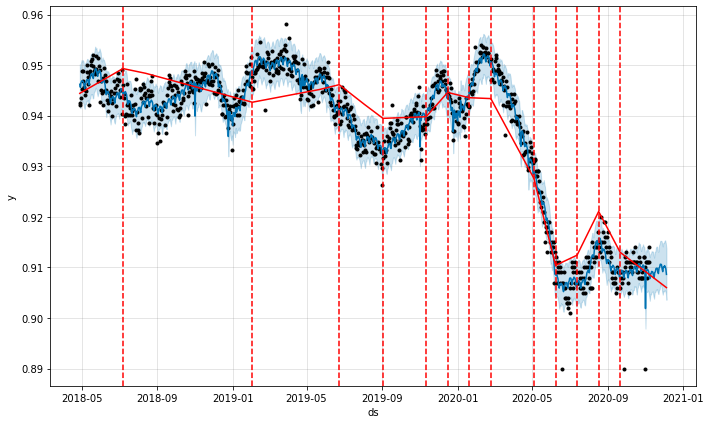

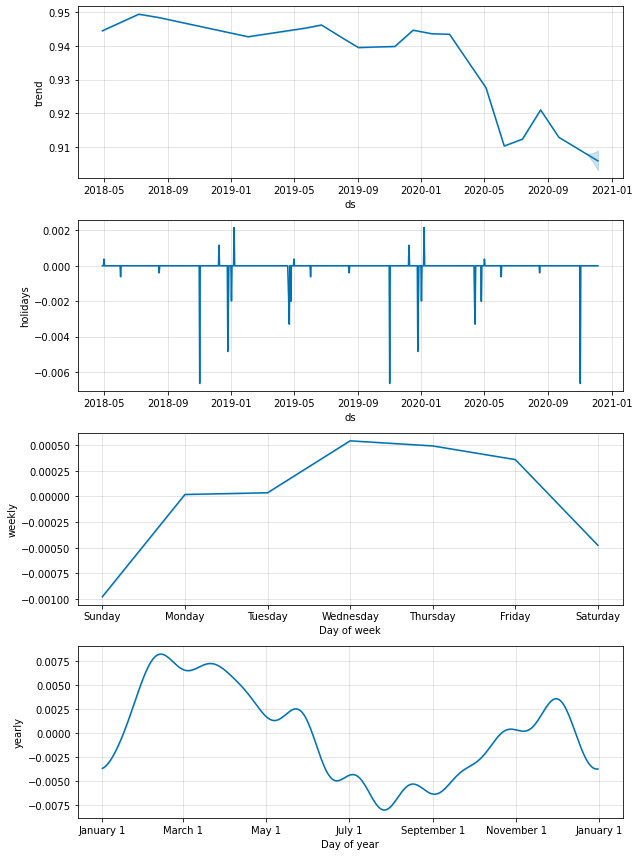

In [ ]:
df_pred, m, seasonalities = fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=changepoint_prior_scale, # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

### A.2 Detect Anomalies in the data, and export the full table of predictions
The table below contains the output of the model. It contains the following columns:
* **ds**: date/time of the observation
* **trend**: underlying trend in case of no seasonal/holidays effect. It’s the g(t) in the formula above
* **yhat_lower / upper**: lower/upper limit of the interval of confidence of the predictions
* **yearly / weekly / daily**: seasonal effects on the prediction for each ds. It’s the s(t) in the formula above
* **holidays**: seasonal effect of the holidays on the prediction for each ds.
It’s the h(t) in the formula above
* **yhat**: Predicted value considering all the effects. 
It’s the y(t) in the formula above
* **fact**: Real observed value, useful to compare it with yhat and check the performance of the predictions
* **anomaly**: Categoric variables used to signal if observed values are higher/lower than the interval of confidence created
  * anomaly = 1 if fact > yhat_upper
  * anomaly = -1 if fact < yhat_lower
  * anomaly = 0 if yhat_lower < fact < yhat_upper
* **importance**: importance of the anomaly in % terms. 
  * if anomaly = 1: importance = fact - yhat upper
  * if anomaly = -1: importance = yhat lower - fact

A **sample** of the table is reported below, while the whole table (including all observations) is being **exported** in a file with the name specified by the  *f_out_name* parameter below

In [ ]:
#### IMPORTANT: Be sure to have the output path in your Gdrive: "drive/My Drive/DSci_Conference_Nov20_iMediaTamKPIs_FD&RT/Output/"
f_out_name = f"{y_var}_predictions.csv"    # Choose the desired output file name

df_anomalies = detect_anomalies(df_pred)
print(f"N° of anomalies: {len(df_anomalies[df_anomalies['anomaly']!=0])} on {len(df_anomalies)} rows"
      f" ({len(df_anomalies[df_anomalies['anomaly']!=0]) / len(df_anomalies):0.1%} of total)")
df_anomalies.to_csv(f"{output_path}{f_out_name}")
print(f"Exported df containing anomalies & predictions")
df_anomalies[df_anomalies['anomaly']!=0].head()

N° of anomalies: 70 on 951 rows (7.4% of total)
Exported df containing anomalies & predictions


,ds,trend,yhat_lower,yhat_upper,holidays,weekly,yearly,yhat,fact,anomaly,importance
15,2018-05-13,0.945466,0.942252,0.950020,0.0,-0.000977,0.001608,0.946098,0.9422,-1,0.000056
22,2018-05-20,0.945956,0.943464,0.951393,0.0,-0.000977,0.002379,0.947358,0.9520,1,0.000637
33,2018-05-31,0.946726,0.944817,0.952874,0.0,0.000493,0.001498,0.948718,0.9428,-1,0.002139
38,2018-06-05,0.947076,0.942675,0.950924,0.0,0.000036,-0.000244,0.946869,0.9421,-1,0.000611
68,2018-07-05,0.949177,0.941384,0.949648,0.0,0.000493,-0.004340,0.945330,0.9404,-1,0.001047


### A.3 Diagnostics: cross validation for a range of historical cutoffs to measure forecast error
Perform cross-validation selecting cutoff points in the past and by fitting the model for each of them using data only up to that cutoff point.

This technique has many advantages on the simple split of train & test set, in fact it uses many train & test sets (at different periods), and  compute the average performance on them, providing more reliable forecast errors and increasing the generalizability of the model.

#### A.3.1 Use the cross_validation functions. Specify the following parameters:
* **initial**: the size of the initial training period
* **period**: the spacing between cutoff dates
* **horizon**: the forecast horizon
* **Output**: A df containing observed (y) and predicted (yhat) values, at each simulated forecast date and each cutoff date. A forecast is made for every observed point between cutoff and cutoff + horizon. 

Periods must be specified using pd.Timedelta compatible style (e.g. '5 days', '3 hours', '10 seconds').

For reference: https://facebook.github.io/prophet/docs/diagnostics.html

In [ ]:
df_cv = cross_validation(m,
                         initial = cv_initial, # "400 days"
                         period  = cv_period,  # "45 days"
                         horizon = cv_horizon  # "60 days"
                         )
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-17,0.941760,0.938188,0.945107,0.9419,2019-06-16
1,2019-06-18,0.941453,0.937839,0.944723,0.9402,2019-06-16
2,2019-06-19,0.942263,0.938603,0.945854,0.9408,2019-06-16
3,2019-06-20,0.942110,0.938812,0.945655,0.9422,2019-06-16
4,2019-06-21,0.942071,0.938405,0.945835,0.9430,2019-06-16


#### A.3.2. Compute accuracy of the prediction

* **MSE**: Mean Squared Error
* **RMSE**: Root Mean Squared Error
* **MAE** Mean Absolute Error
* **MAPE**: Mean Absolute Percentage Error

These are computed on a rolling window of the predictions in df_cv (rolling_window parameter) after sorting by horizon (ds minus cutoff). 

The 1° table below shows a sample of the accuracy of predictions varying the horizon period.

The 2° table below shows more generally the basic descriptive statistics of the performances. It's particularly important to pay attention to the mean of MAPE because it assess the Mean Average Percentage Error that we can expect applying this model to future data.

In [ ]:
f_out_name = f"{y_var}_performance.csv"    # Choose the desired output file name

df_p = performance_metrics(df_cv)
df_p.to_csv(f"{output_path}{f_out_name}", index=False)
print(f"Exported df containing performance of Prophet model")
print("Descriptive statistics for each performance metric:")
df_p.drop(axis=1,columns={"horizon"}).describe()

Exported df containing performance of Prophet model
Descriptive statistics for each performance metric:


,mse,rmse,mae,mape,mdape,coverage
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.000107,0.009757,0.007533,0.008159,0.006050,0.337750
std,0.000070,0.003402,0.002583,0.002814,0.001840,0.079297
min,0.000024,0.004897,0.003718,0.004013,0.002939,0.167832
25%,0.000048,0.006898,0.005082,0.005486,0.004627,0.289510
50%,0.000095,0.009733,0.007455,0.008073,0.005499,0.349650
75%,0.000157,0.012520,0.009452,0.010251,0.007135,0.384615
max,0.000242,0.015553,0.011978,0.013014,0.010483,0.541259


#### A.3.3 Visualize Cross validation performance metrics
* **Dots** show the error for each prediction in df_cv. 
* **The blue line** shows the metric selected (mse, rmse, mae, mape), where the mean is taken over a rolling window of the dots
* The **rolling_window** parameter specifies the proportion of forecasts to use in each rolling window (default=0.1, corresponding to 10% of rows from df_cv included in each window). Increasing this will lead to a smoother average curve in the figure.

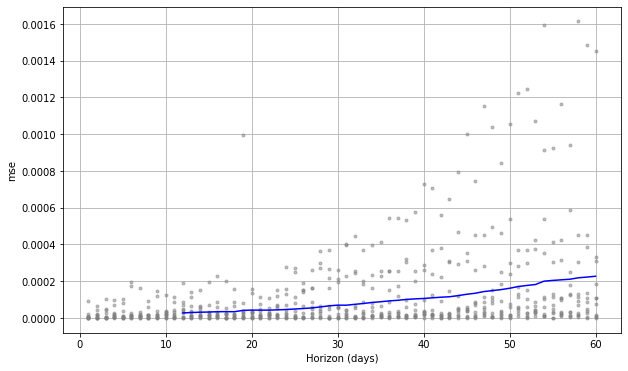

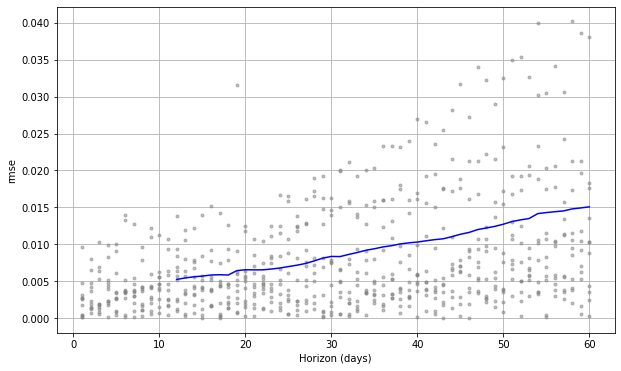

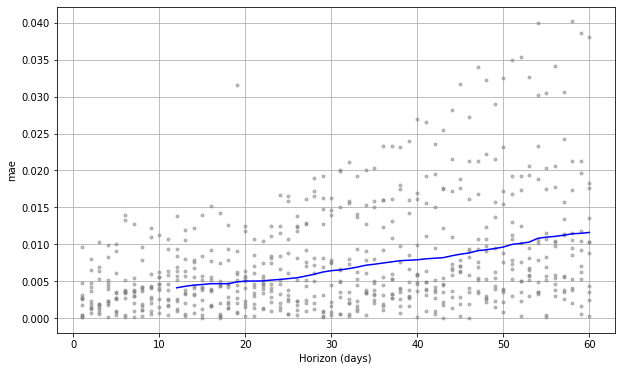

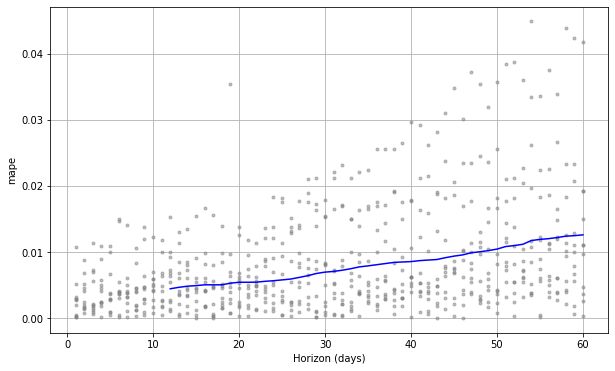

In [ ]:
list_metrics = ["mse", "rmse", "mae", "mape"]
for metrics_i in list_metrics:
    fig = plot_cross_validation_metric(df_cv,
                                       metric=metrics_i,
                                       rolling_window=cv_rolling_window)

### A.4 Models comparison & parameters fine-tuning
In this section we compare 2 or more different models having different parameters (editable manually in the fit_predict function).
Once the models are fitted, it’s possible to compare the results obtained in order to identify which parameters return the best performance.
This is done first graphically (A.4.1), and then performing a grid-search (A.4.2).

#### A.4.1. Fit & compare 2 or more models having some different parameters

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)


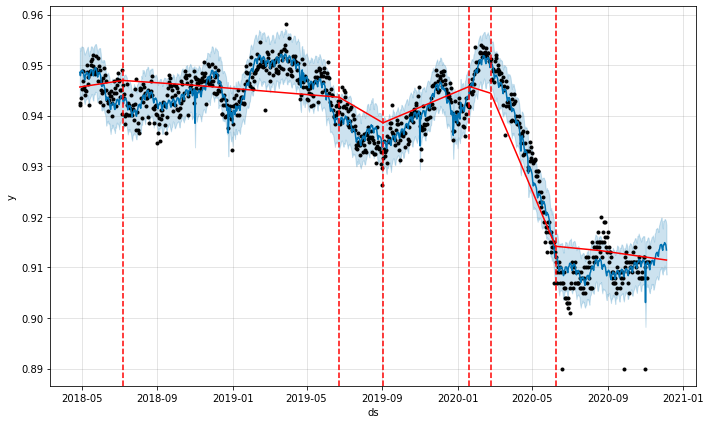

In [ ]:
df_pred1, m1, seasonalities = fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=False,   # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=False,         # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.005,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
    )

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)


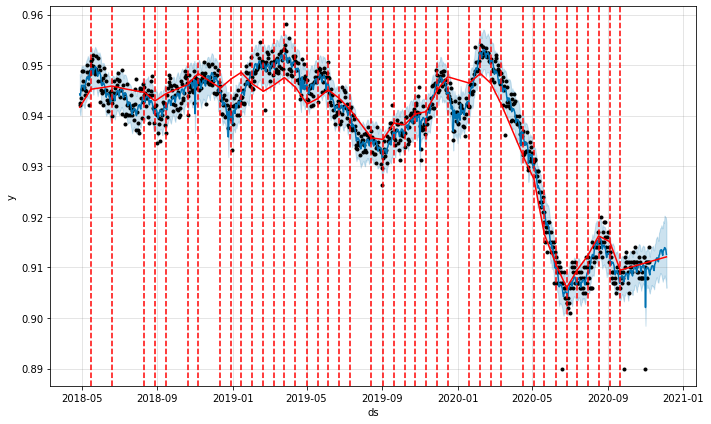

In [ ]:
df_pred2, m2, seasonalities = fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=False,   # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=False,         # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=50,                               # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.25,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

#### A.4.2. Create a grid of parameters to iteratively fit models & compare their diagnostic metrics
The grid-search creates Diagnostics results (same of section A.3) iteratively for each combination of models and parameters.
In this case are provided 3 different models (3 different settings).

The table below shows the performance of the 3 models fitted sorted in the way it was passed (1° row contains results of model m, 2° row of m1, 3° row of m2)

In [ ]:
param_grid = {'model'   : [m, m1, m2],
              'initial' : [cv_initial],
              'period'  : [cv_period],
              'horizon' : [cv_horizon]}
param_grid = list(create_grid(param_grid))

cv_table = cross_validation_compare_models(cross_valid_params=param_grid, metric='mape')
cv_table

INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


,horizon,mse,rmse,mae,mape,coverage,initial,period
0,60 days,0.000108,0.010410,0.007528,0.008154,0.356601,400 days,45 days
0,60 days,0.000110,0.010491,0.007758,0.008418,0.386950,400 days,45 days
0,60 days,0.000100,0.009992,0.007818,0.008404,0.594841,400 days,45 days


# B. MULTIVARIATE PROPHET MODELING: y(t) = g(t) + s(t) + h(t) + et
* **Exogenous variables** are included in the h(t) term

In [ ]:
ts_multiv = create_ts(df=df, date_var=date_var, y_var=y_var, x_vars=x_vars, sort_ts=True)
ts_multiv.head()

,ds,y,Polled,InDirectory
1,2018-04-28,0.9426,0.9776,0.9866
2,2018-04-29,0.9421,0.9767,0.9866
3,2018-04-30,0.9435,0.9780,0.9870
4,2018-05-01,0.9453,0.9754,0.9870
5,2018-05-02,0.9488,0.9769,0.9868


### B.1 Fit the Prophet model (for past & future observations):

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


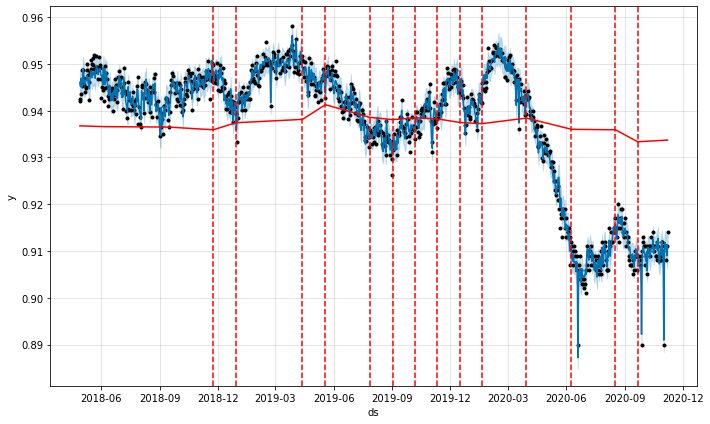

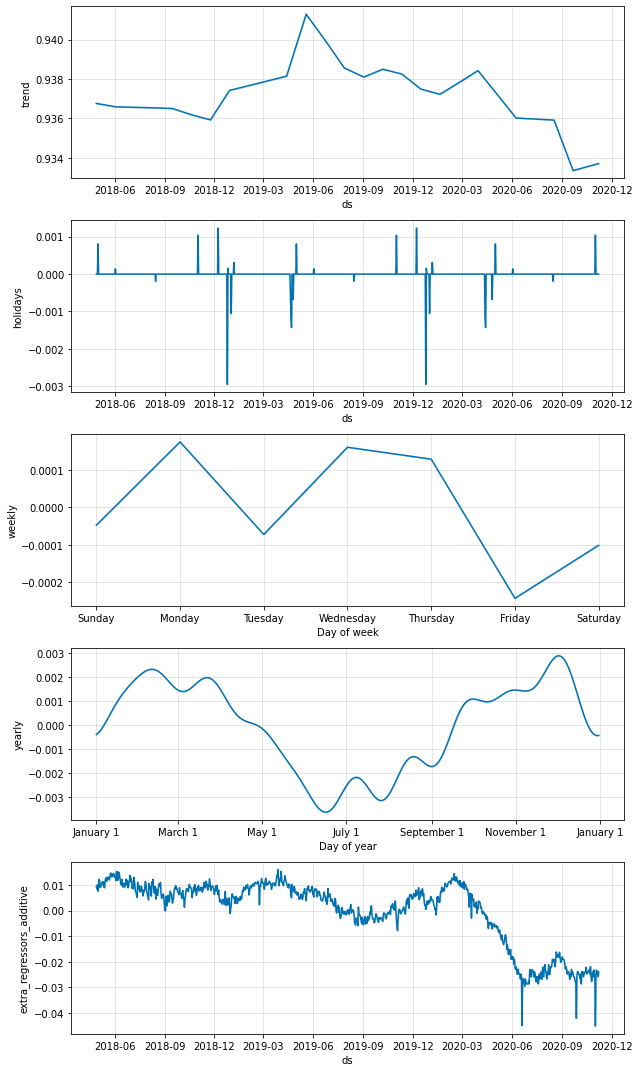

In [ ]:
df_pred_multiv, m_multiv, seasonalities = fit_predict(
    df=ts_multiv,           # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    x_vars=x_vars,                 # List, Exogenous regressors used to fit y. Note: To predict the future, a dataframe of exogenous regressors is required (default=False)
    x_standardize=x_standardize,   # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=False,                        # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=changepoint_prior_scale, # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

### B.2 Detect Anomalies in the data and export the full table of predictions

In [ ]:
f_out_name = f"{y_var}_predictions_multiv.csv"    # Choose the desired output file name

df_anom_multiv = detect_anomalies(df_pred_multiv)
print(f"N° of anomalies: {len(df_anom_multiv[df_anom_multiv['anomaly']!=0])} on {len(df_anom_multiv)} rows")
df_anom_multiv.to_csv(f"{output_path}{f_out_name}")
print(f"Exported df containing anomalies & predictions")
df_anom_multiv[df_anom_multiv['anomaly']!=0].head()

N° of anomalies: 91 on 923 rows
Exported df containing anomalies & predictions


,ds,trend,yhat_lower,yhat_upper,InDirectory,Polled,holidays,weekly,yearly,yhat,fact,anomaly,importance
0,2018-04-28,0.936762,0.943433,0.948581,0.004888,0.004520,0.0,-0.000101,-0.000014,0.946054,0.9426,-1,0.000883
1,2018-04-29,0.936757,0.942773,0.947653,0.004888,0.003657,0.0,-0.000048,-0.000046,0.945207,0.9421,-1,0.000715
2,2018-04-30,0.936752,0.944546,0.949414,0.005232,0.004904,0.0,0.000175,-0.000083,0.946980,0.9435,-1,0.001109
4,2018-05-02,0.936742,0.943200,0.948204,0.005060,0.003849,0.0,0.000161,-0.000172,0.945640,0.9488,1,0.000629
15,2018-05-13,0.936688,0.942252,0.947126,0.005834,0.003177,0.0,-0.000048,-0.000954,0.944697,0.9422,-1,0.000055


### B.3 Diagnostics: cross validation for a range of historical cutoffs to measure forecast error

#### B.3.1 Use the cross_validation functions. Specify the following parameters:

In [ ]:
df_cv_multiv = cross_validation(m_multiv,
                                initial = cv_initial,
                                period  = cv_period,
                                horizon = cv_horizon)
df_cv_multiv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-17,0.940379,0.937941,0.942698,0.9419,2019-06-16
1,2019-06-18,0.940180,0.937510,0.942522,0.9402,2019-06-16
2,2019-06-19,0.941858,0.939468,0.944254,0.9408,2019-06-16
3,2019-06-20,0.942381,0.940000,0.944840,0.9422,2019-06-16
4,2019-06-21,0.943613,0.941179,0.945977,0.9430,2019-06-16


#### B.3.2. Compute accuracy of the prediction, as a function of the distance from the cutoff (how far into the future the prediction was), and export the file of performance

In [ ]:
f_out_name = f"{y_var}_performance_multiv.csv"    # Choose the desired output file name

df_p_multiv = performance_metrics(df_cv_multiv)
df_p_multiv.to_csv(f"{output_path}{f_out_name}", index=False)
print(f"Exported df containing performance of Prophet model")
df_p_multiv.head()
print(df_p_multiv.head())

# Show descriptive statistics of performances
df_p_multiv.drop(axis=1,columns={"horizon"}).describe()

Exported df containing performance of Prophet model
  horizon       mse      rmse       mae      mape     mdape  coverage
0  6 days  0.000004  0.002042  0.001590  0.001712  0.001283  0.772028
1  7 days  0.000004  0.002037  0.001589  0.001712  0.001295  0.755245
2  8 days  0.000004  0.002046  0.001617  0.001742  0.001345  0.774825
3  9 days  0.000004  0.001913  0.001545  0.001666  0.001345  0.804196
4 10 days  0.000004  0.001897  0.001529  0.001650  0.001289  0.818182


,mse,rmse,mae,mape,mdape,coverage
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.000007,0.002697,0.002069,0.002232,0.001696,0.705531
std,0.000002,0.000437,0.000358,0.000390,0.000420,0.058021
min,0.000004,0.001897,0.001523,0.001641,0.001163,0.590210
25%,0.000006,0.002358,0.001786,0.001927,0.001344,0.659441
50%,0.000008,0.002769,0.001998,0.002159,0.001574,0.723077
75%,0.000009,0.003025,0.002390,0.002583,0.002027,0.748252
max,0.000014,0.003675,0.002949,0.003191,0.002745,0.818182


#### C.3.3 Visualize Cross validation performance metrics

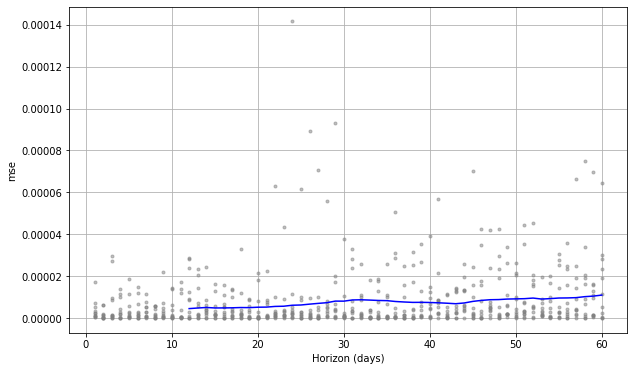

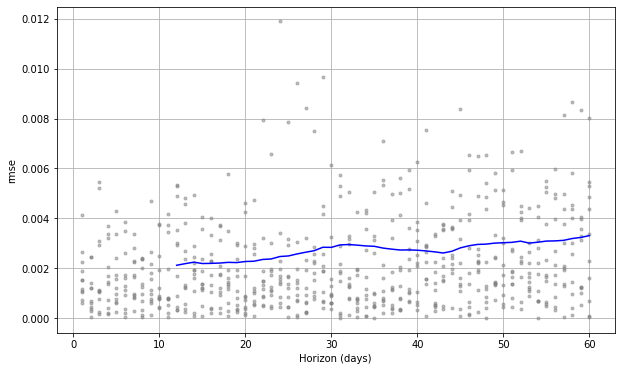

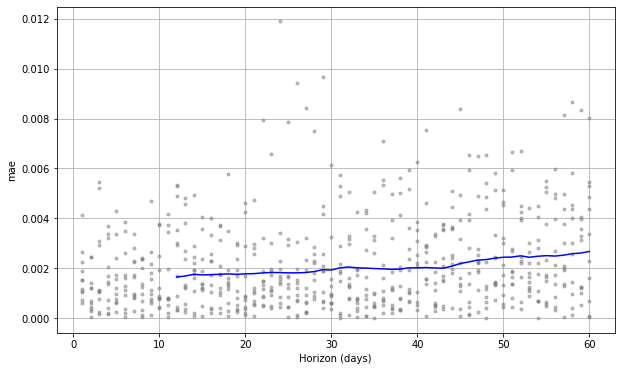

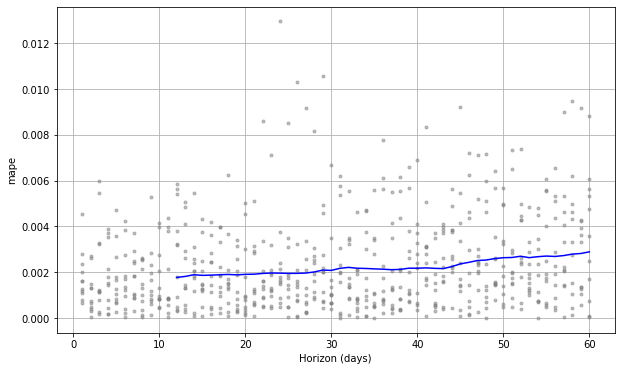

In [ ]:
list_metrics = ["mse", "rmse", "mae", "mape"]
for metrics_i in list_metrics:
    fig = plot_cross_validation_metric(df_cv_multiv,
                                       metric=metrics_i,
                                       rolling_window=cv_rolling_window)

### C.4 Models comparison & parameters fine-tuning

#### C.4.1. Fit & compare 2 or more models having some different parameters

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


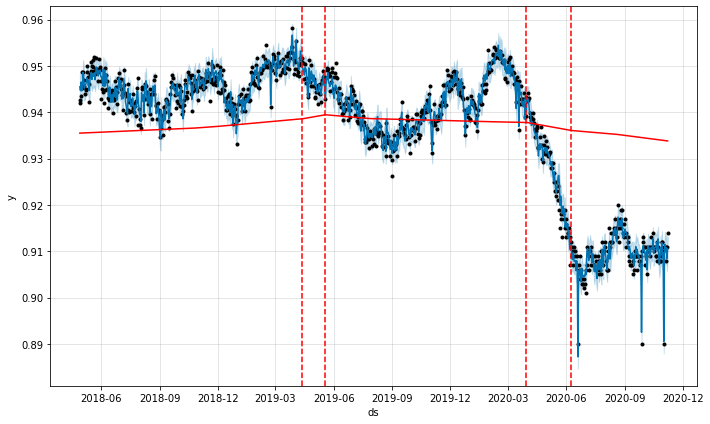

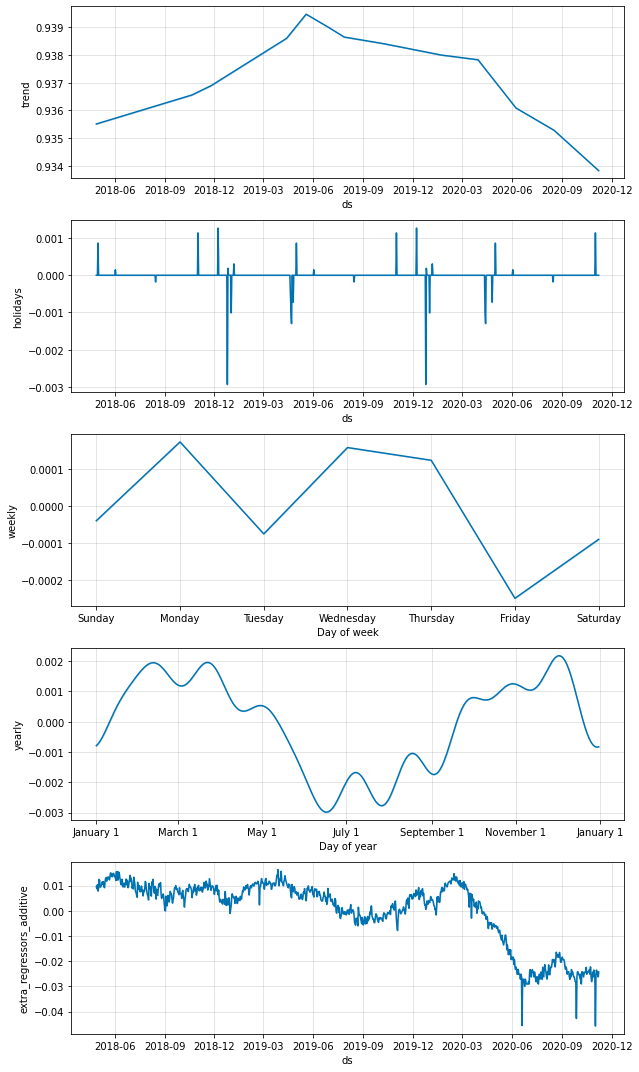

In [ ]:
df_pred_multiv, m1_multiv, seasonalities = fit_predict(
    df=ts_multiv,          # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    x_vars=x_vars,                 # List, Exogenous regressors used to fit y. Note: To predict the future, a dataframe of exogenous regressors is required (default=False)
    x_standardize=x_standardize,   # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=False,                        # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.01,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
    )

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


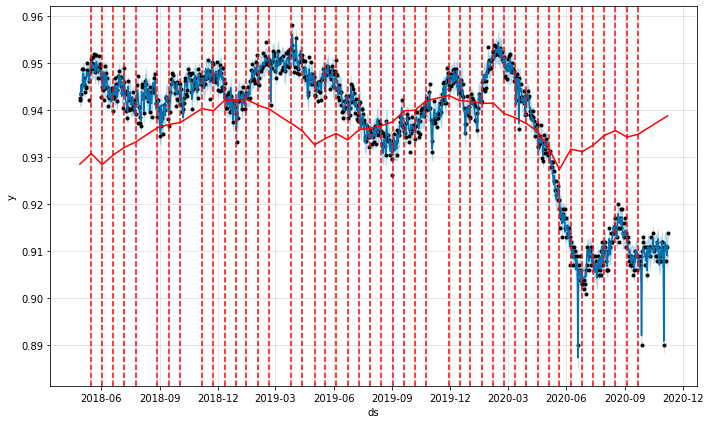

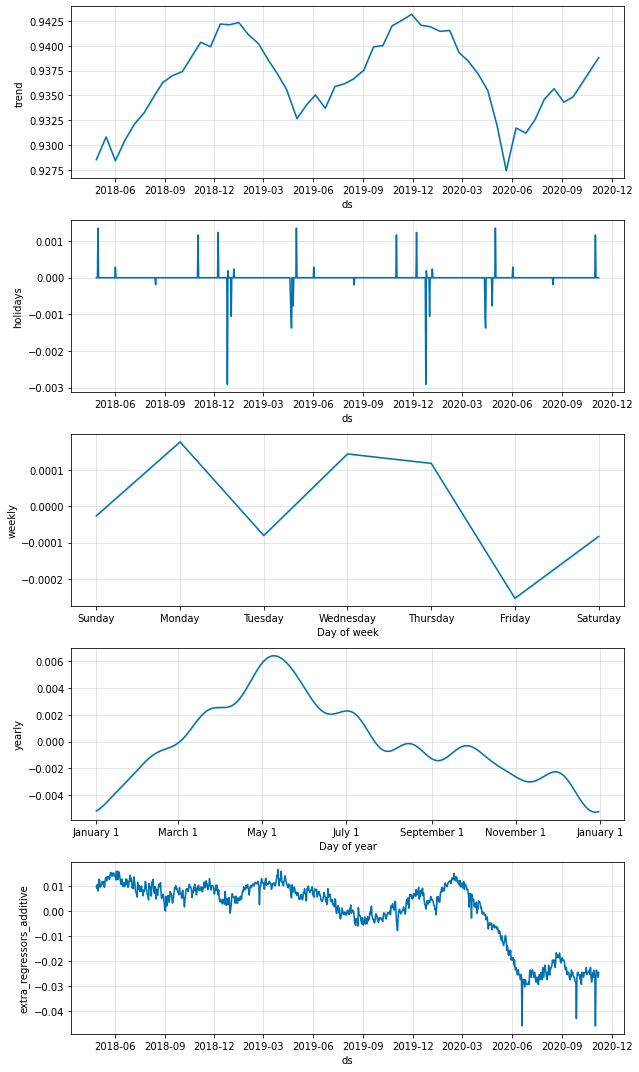

In [ ]:
df_pred_multiv, m2_multiv, seasonalities = fit_predict(
    df=ts_multiv,          # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    x_vars=x_vars,                 # List, Exogenous regressors used to fit y. Note: To predict the future, a dataframe of exogenous regressors is required (default=False)
    x_standardize=x_standardize,   # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=False,                        # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=50,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.25,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
    )

#### C.4.2. Create a grid of parameters to iteratively fit models & compare their diagnostic metrics

In [ ]:
param_grid_multiv = {'model'   : [m_multiv, m1_multiv, m2_multiv],
                     'initial' : [cv_initial],
                     'period'  : [cv_period],
                     'horizon' : [cv_horizon]}

param_grid_multiv = list(create_grid(param_grid_multiv))
param_grid_multiv

cv_table_multiv = cross_validation_compare_models(cross_valid_params=param_grid_multiv, metric='mape')
cv_table_multiv

INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-06-16 00:00:00 and 2020-09-08 00:00:00


,horizon,mse,rmse,mae,mape,coverage,initial,period
0,60 days,0.000008,0.002760,0.002089,0.002255,0.704097,400 days,45 days
0,60 days,0.000009,0.003023,0.002276,0.002460,0.641882,400 days,45 days
0,60 days,0.000049,0.007034,0.005275,0.005665,0.696510,400 days,45 days
